# Latent Dirichlet allocation (LDA)

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [2]:
#import data
comments = pd.read_csv('comments.csv')[['comments']].dropna().drop_duplicates()
len(comments['comments'])

4236

In [3]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                               'good','great', 'nice',
                               'ride','route','road','rt','roads'
                              })

## Text Processing

In [4]:
ngram_range = (2, 3)

vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = comments.comments.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [5]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 312243


In [6]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [19]:
#LDA model parameters
num_topics = 6
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.006*"beautiful scenery" + 0.004*"little traffic" + 0.004*"elevation '
  'changes" + 0.003*"places stop" + 0.003*"speed limit" + 0.003*"highly '
  'recommend" + 0.003*"twists turns" + 0.003*"ridden times" + 0.003*"sure '
  'stop" + 0.003*"lots curves"'),
 (1,
  '0.003*"tail dragon" + 0.003*"speed limit" + 0.003*"beautiful scenery" + '
  '0.002*"twists turns" + 0.002*"years ago" + 0.002*"little traffic" + '
  '0.002*"tellico plains" + 0.002*"highly recommend" + 0.002*"general store" + '
  '0.002*"hot springs"'),
 (2,
  '0.003*"state park" + 0.003*"rock state park" + 0.003*"rock state" + '
  '0.002*"eureka springs" + 0.002*"tail dragon" + 0.002*"circle tour" + '
  '0.002*"poudre canyon" + 0.002*"bucket list" + 0.002*"park beautiful" + '
  '0.002*"curves tight"'),
 (3,
  '0.002*"west coast" + 0.001*"weekend traffic" + 0.001*"right left" + '
  '0.001*"stay right" + 0.001*"beautiful park" + 0.001*"best rode" + '
  '0.001*"entire trip" + 0.001*"ar 21" + 0.001*"lots motorcycles" + '


In [20]:
# get_document_topics method shows the topics found 
# in each corpus doc
lda_model.get_document_topics(corpus[1])

[(0, 0.5821752),
 (1, 0.02336336),
 (2, 0.01791803),
 (3, 0.13124743),
 (4, 0.012361611),
 (5, 0.23293431)]

In [21]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [22]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [23]:
# len(main_topic_df)

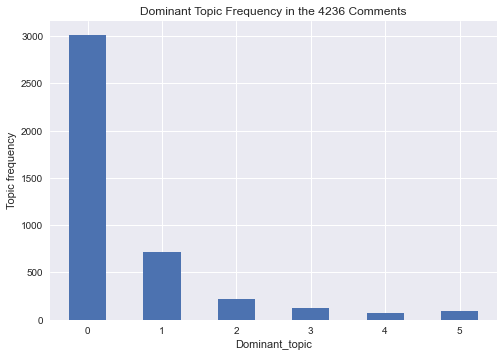

In [24]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(comments)} Comments',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [25]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 11  
        Dominant topic: 0
 
    
Just completed Red Bluff to Fortuna on route 36. Unbelievable! Here in the UK we have some twisties but none that go on for 140 miles through spectacular scenery on roads that no one else seems to use! Rode "two up" on a 2006 Harley Softail Heritage which was good for the first 70 miles but very limited thereafter. Asked several people in Red Bluff if there was fuel on the way but no one knew. Why? Because no one used the road. On hearing that, I brimmed the bikewith premium, rode past the sign "twisties next 140 miles", held my breath and hoped for the best as the Harley was good on the straights for 130'ish miles from a tank. The first 40 odd miles are sweeping curves on glorious tarmac with supreme contours in the road. Through ranching country towards the snow-capped hills, after 48 miles there is Plantina. One store with one gas pump selling regular. Filled up, had a coffee and a chat with the lady who must see very few peop

## Length of documents in each topic

In [26]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [27]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=5), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

Indices of top words: 
{7682, 17923, 388, 24965, 24966, 29831, 86280, 650, 17931, 15759, 56725, 792, 665, 1690, 1309, 3874, 7844, 2982, 14502, 83114, 86199, 46391, 3898, 14650, 25916, 95931, 5566, 9281, 5315, 4550, 2250, 36171, 14541, 16718, 46035, 24440, 4950, 17494, 13271, 7385, 5593, 72025, 14169, 96221, 73955, 34151, 3051, 10732, 9453, 6514, 8691, 3317, 15992, 20474}



[Text(0, 0.5, 'Word frequency'),
 Text(0.5, 1.0, 'Word Frequencies by Topic, Combining the Top 54 Words in Each Topic')]

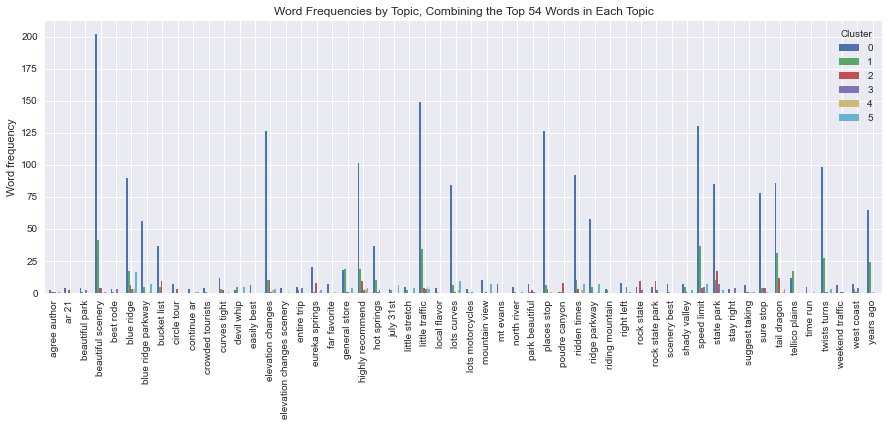

In [28]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']
(
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7)
    .set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')
)

## Coherence scores based on number of topics

In [17]:
coherence_scores = []

for n in range(1, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

Coherence scores for the ngram range: (2, 3) 
 [(1, 0.2481953894927499), (2, 0.36974942871513117), (3, 0.49621836131342634), (4, 0.506817108993558), (5, 0.5694850700442649), (6, 0.5783379905360885), (7, 0.6018908634055268), (8, 0.5923857622727005), (9, 0.5965844116374854), (10, 0.5790567928589875)]


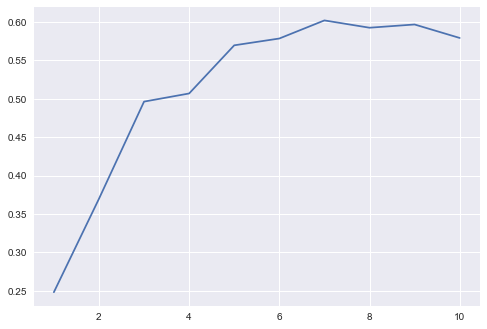

In [18]:
print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
plt.plot(topic_range,cscore)

# Conclusions

- There seem to be 3-4 groups of users making comments on this website.
- IF 3:
    0. The 'core' group of users make most of the comments.
    1. The second group are those who are not as frequent commenters, but when they do post, they usually share videos/links to other sites.
    2. The last group do not frequently comment or share videos/links.
- IF 4:
    0. The 'core' group of users make most of the comments.
    1. Post like core group, but less overall. Maybe newer members/budding 'core' group?
    2. People riding the tail of the dragon.
    3. Other infrequent posters.